# Détection Pierre-feuille-ciseaux 

Pierre-papier-ciseaux est un jeu effectué avec les mains.

A partir d'images de main, nous allons créer un modèle permettant de classifier si la personne joue une pierre, une feuille ou une paire de ciseaux.


#◢  Chargement des données

Commençons par télécharger le jeu de données d'entrainement et de test. 

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2021-07-08 11:27:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M  63.1MB/s    in 3.0s    

2021-07-08 11:27:51 (63.1 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2021-07-08 11:27:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Savin

Les fichiers seront dézippés dans le repertoire tmp. Si vous utilisez Google Calab, vous pouvez accéder à l'arborescence de fichiers via le menu fichier à gauche de la fenêtre.

In [2]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [3]:
rock_dir = os.path.join('/tmp/rps/rock')
# TODO Définir les chemins pour les images représentant des feuilles et des ciseaux
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
# TODO Afficher le nombre d'images représentant des feuilles et des ciseaux
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

# TODO Obtenir la liste des images représentant des feuilles et des ciseaux
paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock06ck02-099.png', 'rock06ck02-008.png', 'rock05ck01-049.png', 'rock06ck02-031.png', 'rock05ck01-042.png', 'rock02-033.png', 'rock03-063.png', 'rock02-007.png', 'rock05ck01-010.png', 'rock06ck02-100.png']
['paper06-069.png', 'paper01-044.png', 'paper03-014.png', 'paper06-026.png', 'paper03-015.png', 'paper03-053.png', 'paper07-073.png', 'paper04-060.png', 'paper04-087.png', 'paper02-033.png']
['testscissors03-008.png', 'testscissors03-016.png', 'scissors01-073.png', 'testscissors02-077.png', 'scissors04-109.png', 'scissors02-112.png', 'testscissors03-054.png', 'testscissors01-047.png', 'scissors02-093.png', 'testscissors02-073.png']


#◢  Affichage des données

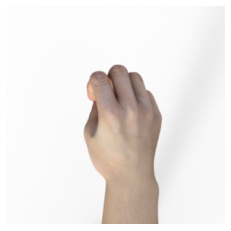

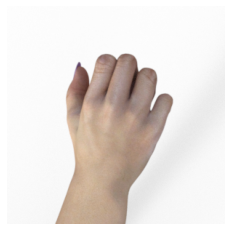

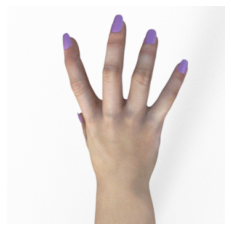

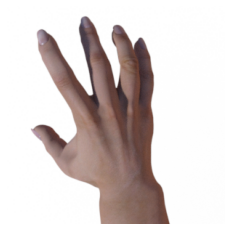

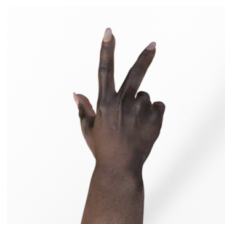

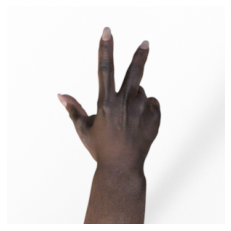

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2


next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  img = mpimg.imread(img_path)
  # TODO Afficher l'image via la librairie matplot
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [5]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

#◢  Data Augmentation

TensorFlow (Keras) propose une API de preprocessing pour les images. 

Cette API permet notamment de parcourir la structure d'un répertoire contenant des images, de les charger et de renvoyer les images (tableaux de pixels) et la sortie (nom du répertoire).

Elle peut également augmenter le jeu de données en appliquant aléatoirement différentes transformations.

La Data Augmentation est une technique qui peut être utilisée pour augmenter artificiellement la taille d'un ensemble de données d'entrainement en créant des versions modifiées des images du dataset.

[Documentation TF d'ImageGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [6]:
TRAINING_DIR = "/tmp/rps/"

# TODO Créer un ImageDataGenerator avec
# en complément des augmentations déjà listées : un rescale de 1./255,  
# un angle de rotation allant de 0 à 40, un retournement horizontal
training_datagen = ImageDataGenerator(
    rescale = 1./255,
	rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# TODO Itérer sur le repértoire d'entrainement avec un batch size de 128
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=128
)

# TODO Créer un ImageDataGenerator avec
# un rescale de 1./255. Attention, sur le jeu de test, nous n'avons 
# pas besoin d'augmenter le jeu de données. 
# Nous validerons le modèle sur un jeu réel.
VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# TODO Itérer sur le repértoire de tests en utilisant le même 
# paramètrage que pour le jeu d'entrainement
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


#◢  Création d'un modèle CNN

In [7]:
# TODO Créer un réseau CNN
model = tf.keras.models.Sequential([
    # TODO créer 3 couches de conv avec un filtre de taille 3x3 + Max Pooling (2x2) 
    # Testez différents configurations en faisant varier le nombre de filters
    # (i.e. the number of output filters in the convolution)                          
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # TODO Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # TODO Créer un réseau dense avec 1 couche intermédiaire de 512 neurones
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# TODO complétez avec les generators
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, 
                    validation_data = validation_generator, 
                    verbose = 1, validation_steps=3,
                    callbacks=[myCallback()])

model.save("rps.h5")

Epoch 1/25
20/20 [==============================] - 52s 993ms/step - loss: 3.4351 - accuracy: 0.3560 - val_loss: 1.0196 - val_accuracy: 0.3871
Epoch 2/25
20/20 [==============================] - 20s 1s/step - loss: 1.0250 - accuracy: 0.5151 - val_loss: 0.7572 - val_accuracy: 0.7796
Epoch 3/25
20/20 [==============================] - 19s 973ms/step - loss: 0.9448 - accuracy: 0.5591 - val_loss: 0.7019 - val_accuracy: 0.6989
Epoch 4/25
20/20 [==============================] - 19s 971ms/step - loss: 0.8284 - accuracy: 0.6667 - val_loss: 0.4739 - val_accuracy: 0.9220
Epoch 5/25
20/20 [==============================] - 20s 975ms/step - loss: 0.6548 - accuracy: 0.7036 - val_loss: 0.5563 - val_accuracy: 0.7231
Epoch 6/25
20/20 [==============================] - 21s 1s/step - loss: 0.6580 - accuracy: 0.7345 - val_loss: 0.3169 - val_accuracy: 0.8199
Epoch 7/25
20/20 [==============================] - 20s 998ms/step - loss: 0.4754 - accuracy: 0.8087 - val_loss: 1.1206 - val_accuracy: 0.6667
Epoch

#◢  Affichage de l'accuracy et du loss

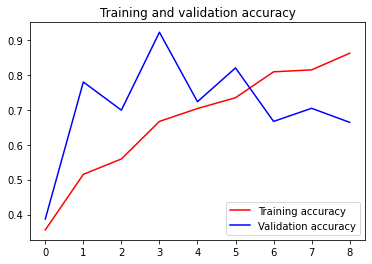

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

#◢  Visualisation des représentations intermédiaires

/tmp/rps/rock/rock03-012.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


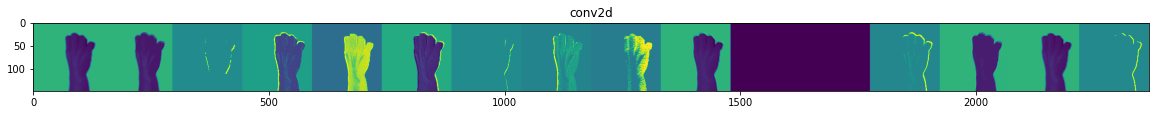

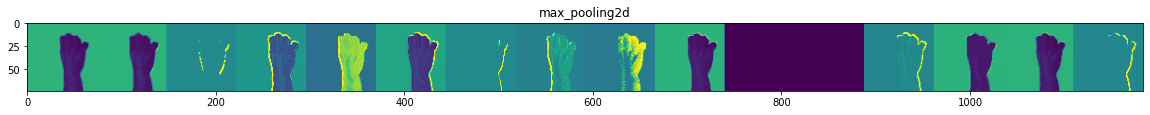

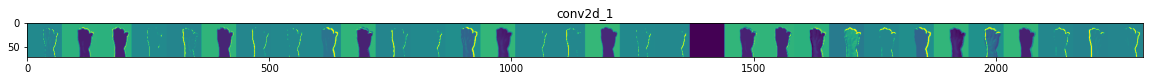

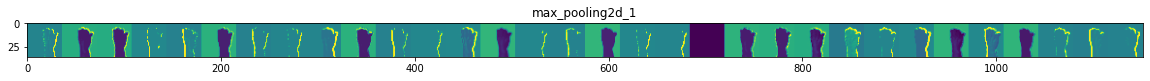

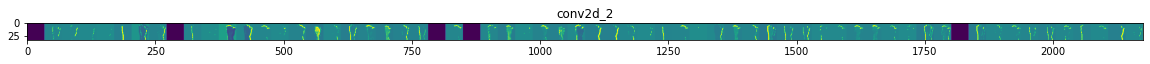

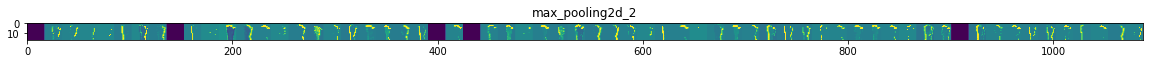

In [13]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

rock_img_files = [os.path.join(rock_dir, f) for f in rock_files]
paper_img_files = [os.path.join(paper_dir, f) for f in paper_files]
scissors_img_files = [os.path.join(scissors_dir, f) for f in scissors_files]

img_path = random.choice(rock_img_files +  paper_img_files + scissors_img_files)

print(img_path)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

#◢  Ajout d'un callback pour arrêter l'entrainement dès lors qu'un seuil est atteint.

Ici nous arrêtons l'entrainement dès que l'accuracy est > à 85%.

Une fois ce callback défini, relancer l'entrainement (fit) du modèle en ajoutant ce callback et notez le comportement.

[Documentation Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)

[Tutoriel Callback](https://www.tensorflow.org/guide/keras/custom_callback)

In [9]:
# TODO Relancer l'apprentissage en ajoutant ce callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85):
      print("\nReached 85% accuracy so cancelling training!")
      self.model.stop_training = True